# Biosignals Processing in Python

In [77]:
# Import packages
import neurokit as nk
import pandas as pd
import numpy as np

# Plotting preferences
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14.0, 10.0]  # Bigger figures

import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind"))

## Import Data

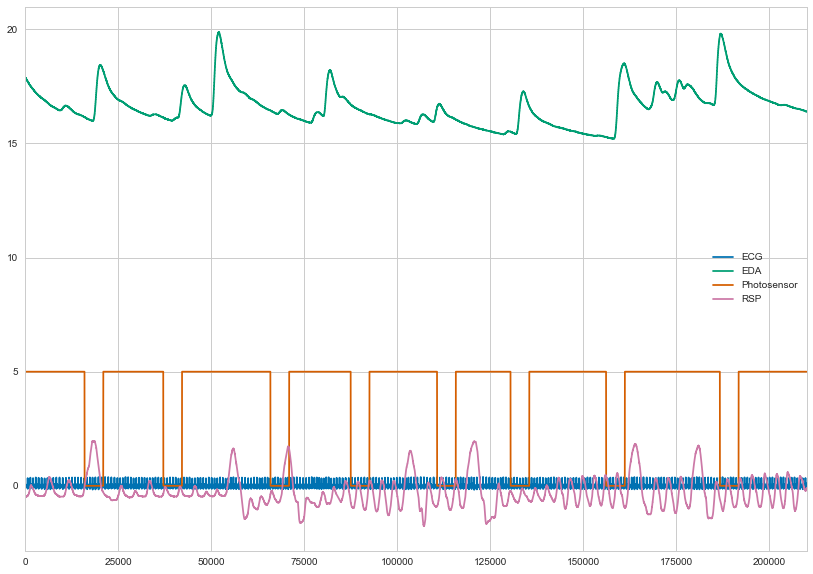

In [79]:
df = pd.read_csv("data_bio.csv")
df.plot()

df contains 3.5 minutes of data recorded at 1000Hz. There are 4 channels, EDA, ECG, RSP and the Photosensor used to localize events.

## Process it

In [59]:
bio = nk.process_bio(ecg=df["ECG"], rsp=df["RSP"], eda=df["EDA"])
bio.keys()  # See what it contains

dict_keys(['EDA_Features', 'Bio_Processed', 'ECG_Features'])

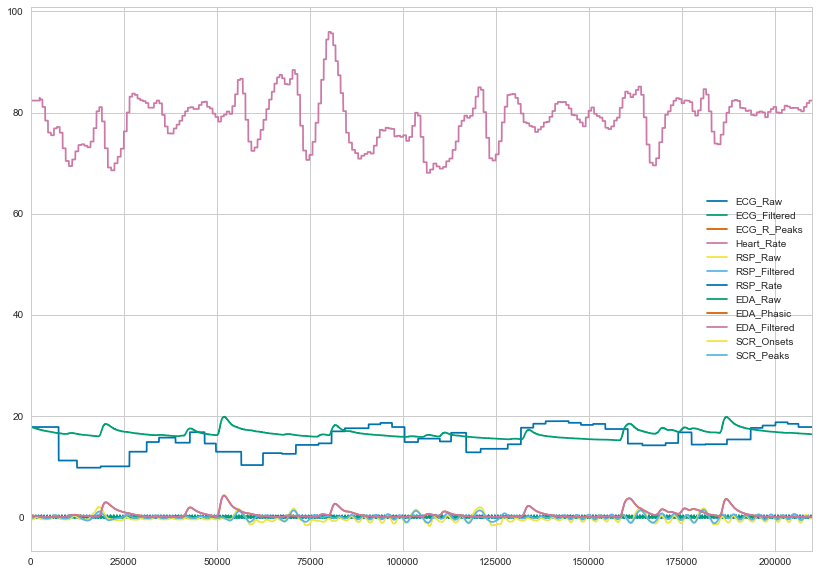

In [80]:
bio["Bio_Processed"].plot()

## ECG Miscellaenous

### Heart Beats

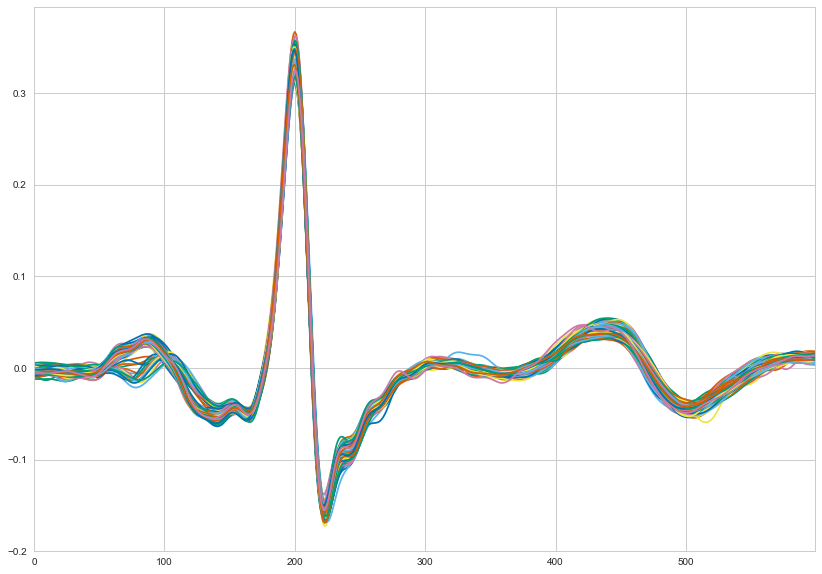

In [81]:
pd.DataFrame(bio["ECG_Features"]["Heart_Beats"]).T.plot(legend=False)  # Plot all the heart beats

This plot contains all 274 detected heart beats synchronized by their R peak.

### Heart Rate Variability (HRV)

In [62]:
# Print all the HRV indices
bio["ECG_Features"]["ECG_HRV"]

{'hf': 235.12,
 'hfnu': 12.27,
 'lf': 1681.79,
 'lf_hf': 7.1500000000000004,
 'lfnu': 87.730000000000004,
 'mhr': 78.969999999999999,
 'mrri': 763.14999999999998,
 'nn50': 13.0,
 'pnn50': 4.7800000000000002,
 'rmssd': 24.699999999999999,
 'sdnn': 50.920000000000002,
 'total_power': 2280.6799999999998,
 'vlf': 363.76999999999998}

## Event-Related Analysis

This experiment consisted of 8 events (when the photosensor signal goes down). 2 types of images were shown to the participant, "Negative" vs "Neutral". The following list is the order.

In [63]:
condition_list = ["Negative", "Negative", "Neutral", "Neutral", "Neutral", "Negative", "Negative", "Neutral"]

### Find Events

First, we must find events onset within our photosensor's signal using the `find_events()` function. This functions requires a treshold and a direction (should it select events that are *higher* or *lower* than the treshold).

In [64]:
events = nk.find_events(df["Photosensor"], treshold = 3, cut="lower")
events

{'duration': array([5030, 5030, 5030, 5031, 5031, 5030, 5030, 5031]),
 'onsets': array([ 15905,  37074,  65874,  87457, 110673, 130425, 156113, 186697])}

### Create Epochs

Then, we divise our dataframe in epochs, *i.e.* segments of data around the event. We set our epochs to start at the event start (`onset=0`) and to last for 5000 data points, in our case equal to 5s (since the signal is sampled at 1000Hz).

In [65]:
epochs = nk.create_epochs(bio["Bio_Processed"], events["onsets"], duration=5000, onset=0)

### Create Evoked-Data

We can then itereate through the epochs and store the interesting results in a new dict that will be, at the end, converted to a dataframe.

In [66]:
evoked = {}  # Initialize an empty dict
for epoch in epochs:
    evoked[epoch] = {}  # Initialize an empty dict for the current epoch
    evoked[epoch]["Heart_Rate"] = epochs[epoch]["Heart_Rate"].mean()  # Heart Rate mean
    evoked[epoch]["RSP_Rate"] = epochs[epoch]["RSP_Rate"].mean()  # Respiration Rate mean
    evoked[epoch]["EDA_Filtered"] = epochs[epoch]["EDA_Filtered"].mean()  # EDA mean
    evoked[epoch]["EDA_Max"] = max(epochs[epoch]["EDA_Filtered"])  # Max EDA value
    
    # SRC_Peaks are scored np.nan (NaN values) in the absence of peak. We want to change it to 0
    if np.isnan(epochs[epoch]["SCR_Peaks"].mean()):
        evoked[epoch]["SCR_Peaks"] = 0
    else:
        evoked[epoch]["SCR_Peaks"] = epochs[epoch]["SCR_Peaks"].mean()

evoked = pd.DataFrame.from_dict(evoked, orient="index")  # Convert to a dataframe
evoked["Condition"] = condition_list  # Add the conditions
evoked  # Print

,EDA_Max,EDA_Filtered,RSP_Rate,Heart_Rate,SCR_Peaks,Condition
0,2.904791,1.119592,9.899207,76.692448,0.002233,Negative
1,1.401832,0.228276,15.088623,77.758983,0.001362,Negative
2,0.333022,0.170198,12.570695,86.674810,0.000000,Neutral
3,0.617933,0.289176,17.845710,71.802572,0.000000,Neutral
4,1.120845,0.700019,15.900692,72.209853,0.000000,Neutral
5,2.199279,1.128347,16.889012,79.131768,0.001678,Negative
6,3.707069,1.398594,17.058763,80.892720,0.002566,Negative
7,3.543960,2.009089,15.289180,81.304369,0.000000,Neutral


### Plot the data

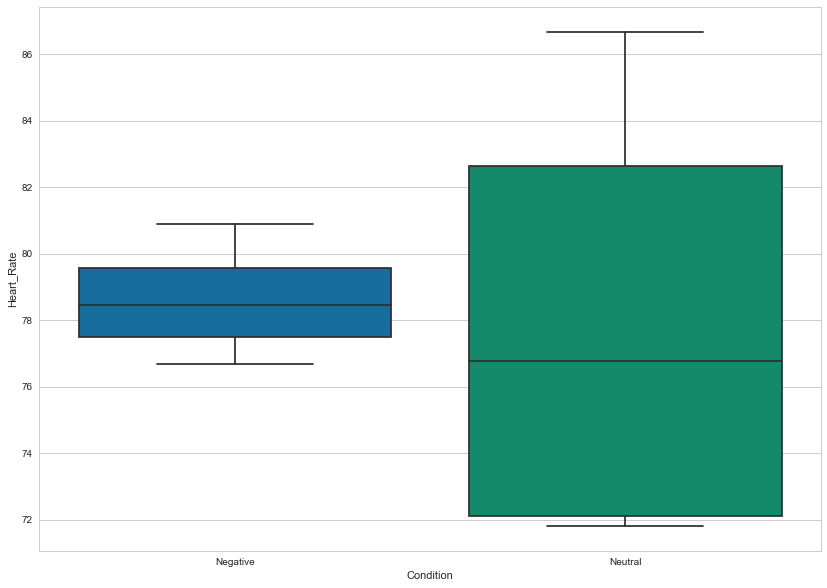

In [82]:
sns.boxplot(x="Condition", y="Heart_Rate", data=evoked)

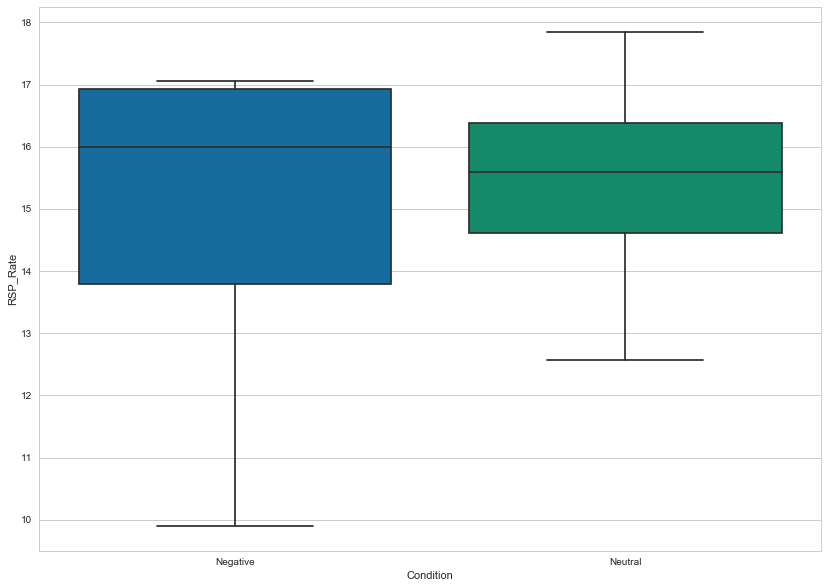

In [83]:
sns.boxplot(x="Condition", y="RSP_Rate", data=evoked)

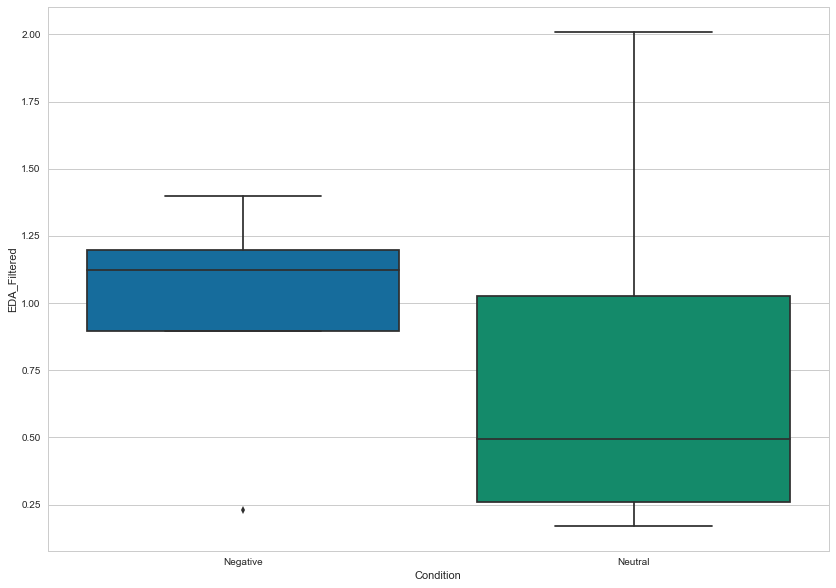

In [84]:
sns.boxplot(x="Condition", y="EDA_Filtered", data=evoked)

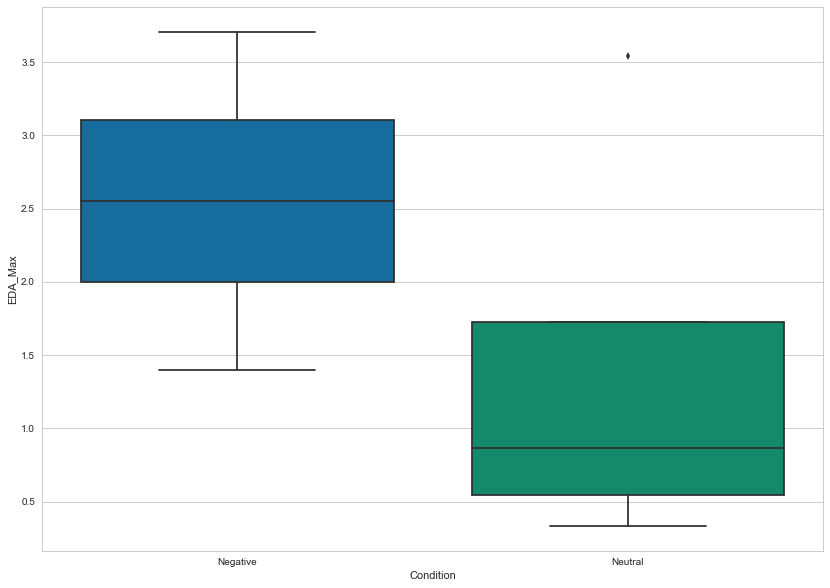

In [78]:
sns.boxplot(x="Condition", y="EDA_Max", data=evoked)

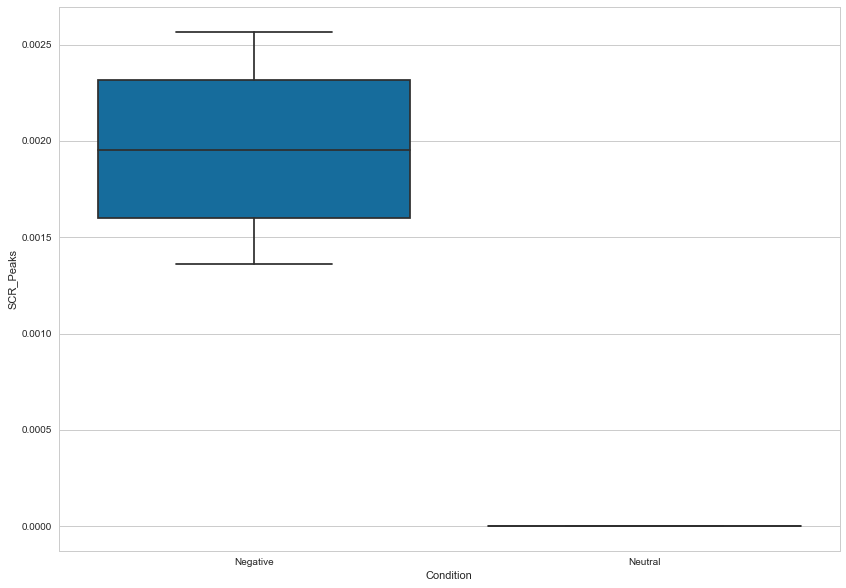

In [85]:
sns.boxplot(x="Condition", y="SCR_Peaks", data=evoked)